In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import librosa
from scipy.io import wavfile
import matplotlib.pyplot as plt
plt.rcParams['agg.path.chunksize'] = 100000
import librosa.display
import scipy
import numpy as np
import os
import csv
import warnings
import tensorflow as tf

from keras.models import Sequential
from keras.layers import *
from sklearn.metrics import *
warnings.filterwarnings("ignore")

# Create Data

In [ ]:
f = open('/content/drive/MyDrive/Modi Real Audio/data.csv', 'w', newline='')
csvwriter = csv.writer(f)
csvwriter.writerow(["audio","target"])

14

In [ ]:
def process(label,filename,target):
    label = f"/content/drive/MyDrive/Modi Real Audio/{label}"
    if os.path.exists(label) == False:
        os.mkdir(label)
 
    y, sr = librosa.load(filename)


    splitedSize = sr*5
    y_all = [ y[ x:x+splitedSize ] for x in range(0, y.shape[0], splitedSize ) ]
    y_all = y_all[:-1]

    for i in range(len(y_all)):
        scipy.io.wavfile.write(f"{label}/{filename.split('/')[-1][:-4]}_{label.split('/')[-1]}_{i}.wav", sr,y_all[i])
        csvwriter.writerow([f"{label}/{filename.split('/')[-1][:-4]}_{label.split('/')[-1]}_{i}.wav",target])

In [ ]:
import glob
for files in glob.glob("/content/drive/MyDrive/Modi Real Audio/Fake_Audio/*"):
    process("fake",files,0)
for files in glob.glob("/content/drive/MyDrive/Modi Real Audio/Real_Audio/*"):
    process("real",files,1)

In [ ]:
f.close()

# Deep Learning

In [ ]:
import pandas as pd
data = pd.read_csv("/content/drive/MyDrive/Modi Real Audio/data.csv")

In [ ]:
audios = data.audio.values
y = data.target.values

X = []
for i in audios:

    x,sr = librosa.load(i)
    mfccs = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=20)
    y_delta = librosa.feature.delta(mfccs)
    mfccs = np.vstack((mfccs,y_delta))
    X.append(mfccs)

X = np.array(X)

In [ ]:
sum(y)

782

In [ ]:
X.shape

(865, 40, 216)

In [ ]:
X = X.reshape(X.shape[0],X.shape[1],X.shape[2],1)

In [ ]:
y.shape

(865,)

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.15, random_state=0)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    break

In [ ]:
rlr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto',
    min_delta=0.0001, cooldown=0, min_lr=0,)

es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0, patience=5,
    verbose=1, mode="auto", baseline=None, restore_best_weights=True,
)

nan = tf.keras.callbacks.TerminateOnNaN()

In [ ]:
model = Sequential()
model.add(Conv2D(16, 3, activation='tanh', input_shape=(X.shape[1],X.shape[2],X.shape[3])))
model.add(Conv2D(32, 3,activation='tanh'))
model.add(MaxPool2D(pool_size=(2, 5)))
model.add(Conv2D(64, 3,activation='tanh'))
model.add(Conv2D(128, 3,activation='tanh'))
model.add(MaxPool2D(pool_size=(2, 5)))

model.add(Flatten())
model.add(Dense(128, activation='tanh'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 38, 214, 16)       160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 36, 212, 32)       4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 18, 42, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 40, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 38, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0

In [ ]:
history = model.fit(X_train, y_train,
                    validation_data =(X_test,y_test),
                    callbacks = [rlr,es,nan],
                    batch_size = 32,
                    epochs=50, verbose=1)

Epoch 1/50
23/23 [==============================] - 44s 55ms/step - loss: 0.3176 - accuracy: 0.9101 - val_loss: 0.2711 - val_accuracy: 0.9154
Epoch 2/50
23/23 [==============================] - 0s 12ms/step - loss: 0.2578 - accuracy: 0.9008 - val_loss: 0.1818 - val_accuracy: 0.9538
Epoch 3/50
23/23 [==============================] - 0s 13ms/step - loss: 0.1609 - accuracy: 0.9342 - val_loss: 0.1382 - val_accuracy: 0.9692
Epoch 4/50
23/23 [==============================] - 0s 13ms/step - loss: 0.1592 - accuracy: 0.9326 - val_loss: 0.1191 - val_accuracy: 0.9769
Epoch 5/50
23/23 [==============================] - 0s 12ms/step - loss: 0.1212 - accuracy: 0.9470 - val_loss: 0.1138 - val_accuracy: 0.9692
Epoch 6/50
23/23 [==============================] - 0s 13ms/step - loss: 0.1312 - accuracy: 0.9358 - val_loss: 0.1114 - val_accuracy: 0.9692
Epoch 7/50
23/23 [==============================] - 0s 12ms/step - loss: 0.1057 - accuracy: 0.9556 - val_loss: 0.1174 - val_accuracy: 0.9538
Epoch 8/50
2

In [ ]:
max(history.history['val_accuracy'])

0.9769230484962463

In [ ]:
Y_pred = model.predict(X_test)
y_pred = np.round(Y_pred)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[  8   4]
 [  1 117]]
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.97      0.99      0.98       118

    accuracy                           0.96       130
   macro avg       0.93      0.83      0.87       130
weighted avg       0.96      0.96      0.96       130



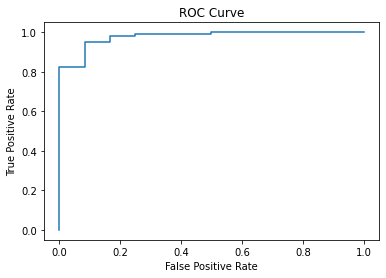

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, Y_pred)
roc_auc = roc_auc_score(y_test, Y_pred)
plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()